# Install and import dependences

In [ ]:
#!pip install --upgrade python-binance tensorflow

In [15]:
from binance.client import Client
from binance import BinanceSocketManager
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from sklearn.metrics import mean_squared_error, confusion_matrix

# Load data

In [16]:
api_key = "imuSkmeAI4PpxNERZRcnzx6nEkReEhuLedZphxZNphhnUPLR4QH61aXfjnBqUtfH"
api_secret = "56AvdFdOWWoRF20rh6Knq8awDYM145luMDH0XvDMkSD6nffbRwYTCrsxwJmyVLK1"
client = Client(api_key, api_secret)

In [17]:
#Get the exchange info, which contains information about all trading pairs
exchange_info = client.get_exchange_info()

#Extract the symbols of all trading pairs
symbols = [symbol['symbol'] for symbol in exchange_info['symbols'] if "BRL" in symbol['symbol']]

#Filter out only the base cryptocurrencies (e.g., BTC, ETH)
symbols = list(symbol.split(' ')[0] for symbol in symbols)

len(symbols)
#print(symbols)

37

In [18]:
# Function to fetch historical cryptocurrency data
def fetch_binance_cryptocurrency_data(symbol, start_date, end_date, interval='1d'):
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)

    # Convert data to a Pandas DataFrame
    df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime

    return df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

database = {}
present_day = dt.date.today()
start_date = '1900-01-01'
end_date = f"{present_day}"
for ticker in symbols:
    data = fetch_binance_cryptocurrency_data(ticker, start_date, end_date)
    database[ticker] = data.close.values.astype(float)
    
#database

# Model functions

In [25]:
def predict(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(32, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [41]:
def predict2(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(16, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [46]:
def predict3(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(8, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [51]:
def predict4(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(8, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [53]:
def predict5(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(64, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(64, activation='relu', return_sequences=True),
        SimpleRNN(48, activation='relu', return_sequences=True),
        SimpleRNN(48, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(4, activation='relu', return_sequences=True),
        SimpleRNN(4, activation='relu', return_sequences=True),
        SimpleRNN(2, activation='relu', return_sequences=True),
        SimpleRNN(2, activation='relu', return_sequences=True),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [10]:
def my_confusion_matrix(true_status: list, pred_status: list):
    cm = confusion_matrix(true_status, pred_status)
    labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    cm = cm.reshape((2, 2))
    
    # Print indices where true and pred statuses are False and True respectively
    false_true_indices = []
    for i in range(len(true_status)):
        if true_status[i] == False and pred_status[i] == True:
            false_true_indices.append(i)
    
    # Calculate accuracy
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    print("CM accuracy:", accuracy)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return false_true_indices 

In [45]:
def sell_price(last_value, pred1, pred2, margin = 0.001):
    'optmize the sell price'
    
    if pred1 <= last_value and abs(last_value - pred1) <= (pred1*0.0025):
        return last_value
    
    if (pred1 - (pred1*margin)) <= last_value:
        return last_value
    
    if pred2/pred1 >= 1.05:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        return pred1 + (pred1 * margin)
    
    if pred2/pred1 >= 1.01:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        return pred1

    else:
        return pred1 - (pred1 * margin)

In [9]:
def check_sold(gamble, true_price, margin = 0.002):
    return my_gamble <= true_price + (true_price * margin)

In [11]:
def num_epochs(x, b=100):
      return int(100 * (x**(1/10)) + b)

# Predictions

Loss: 75872240.0
BTCBRL Count: 1 / LastPrice: 333253.0 / Pred1: 331403.0 / Pred2: 339971.62 / TruePrice1: 343050.0 / TruePrice2: 343983.0 || ActStatus: False / MyActStatus: False / MyGamble: 333253.0 / SoldStatus: None / GambleProft: None / CorrectModel: False
Loss: 0.0015010673087090254
USDTBRL Count: 2 / LastPrice: 4.986 / Pred1: 4.9826317 / Pred2: 5.029587 / TruePrice1: 5.036 / TruePrice2: 5.042 || ActStatus: True / MyActStatus: False / MyGamble: 4.986 / SoldStatus: None / GambleProft: None / CorrectModel: True
Loss: 127389.234375
ETHBRL Count: 3 / LastPrice: 19296.22 / Pred1: 19654.236 / Pred2: 20100.441 / TruePrice1: 19556.48 / TruePrice2: 19605.24 || ActStatus: True / MyActStatus: True / MyGamble: 19654.236 / SoldStatus: False / GambleProft: 1.018553702648757 / CorrectModel: True
Loss: 234.82969665527344
BNBBRL Count: 4 / LastPrice: 2368.0 / Pred1: 2449.4712 / Pred2: 2462.6665 / TruePrice1: 2449.0 / TruePrice2: 2441.0 || ActStatus: True / MyActStatus: True / MyGamble: 2447.021720

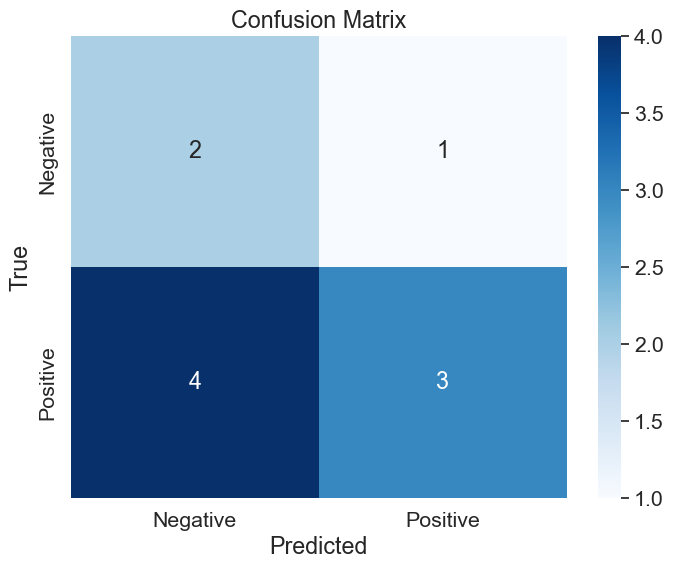

XRPBRL


In [49]:
for lb in [11]:
    count = 0
    pred_status_list, true_status_list = [], []
    last_price_list = []
    pred_1_list, pred_2_list = [], []
    total_last_stock_price, total_gamble_stock_price = 0, 0
    total_pred_stock_price, total_true_stock_price = 0, 0
    total_proft = 0

    for ticker in symbols[:10]:
        count += 1
        price = database[ticker]
        act_status, last_price, pred1, pred2, true_price1, true_price2 = predict(price, look_back = lb, epochs=500, ticker=ticker, plot_graph = False)
            
        my_act_status = act_status
        my_gamble = sell_price(last_price, pred1, pred2)
        gamble_proft = my_gamble/last_price
        sold_status = check_sold(my_gamble, true_price1)
        
        if my_gamble/last_price < 1.0008 and my_act_status == True: 
            my_act_status = False
        if my_act_status == False: 
            sold_status = None
            gamble_proft = None
            
        print(ticker, 'Count:', count, '/ LastPrice:', last_price, '/ Pred1:', pred1, '/ Pred2:', pred2, '/ TruePrice1:', true_price1, '/ TruePrice2:', true_price2, 
              '|| ActStatus:', act_status, '/ MyActStatus:', my_act_status, '/ MyGamble:', my_gamble, '/ SoldStatus:', sold_status, '/ GambleProft:', gamble_proft, '/ CorrectModel:', act_status == ((true_price1 - last_price) > 0))
        
        true_proft = true_price1 - last_price
        pred_status_list.append(act_status)
        last_price_list.append(last_price)
        pred_1_list.append(pred1)
        pred_2_list.append(pred2)
        if act_status:
            total_last_stock_price += last_price
            total_pred_stock_price += pred1
            total_gamble_stock_price += my_gamble
            total_true_stock_price += true_price1
        if true_proft > 0:
            true_status_list.append(True)
        if true_proft <= 0:
            true_status_list.append(False)
            
    if not total_last_stock_price == 0:
        print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
        print('Gamble proft %:', total_gamble_stock_price / total_last_stock_price)
        print('True proft %:', total_true_stock_price / total_last_stock_price)
    if total_last_stock_price == 0:
        print('\nAll False')
        
    print('\nLook_back:', lb)
    index = my_confusion_matrix(true_status_list, pred_status_list)
    for i in index:
        print(symbols[i])

Loss: 45710536.0
BTCBRL Count: 1 / LastPrice: 333253.0 / Pred1: 333784.72 / Pred2: 341621.84 / TruePrice1: 343050.0 / TruePrice2: 343983.0 || ActStatus: True / MyActStatus: True / MyGamble: 333784.72 / SoldStatus: True / GambleProft: 1.0015955407753268 / CorrectModel: True
Loss: 0.0004432101850397885
USDTBRL Count: 2 / LastPrice: 4.986 / Pred1: 5.008708 / Pred2: 5.0539007 / TruePrice1: 5.036 / TruePrice2: 5.042 || ActStatus: True / MyActStatus: True / MyGamble: 5.003699292182922 / SoldStatus: True / GambleProft: 1.0035497978706223 / CorrectModel: True
Loss: 98164.953125
ETHBRL Count: 3 / LastPrice: 19296.22 / Pred1: 19124.797 / Pred2: 19505.334 / TruePrice1: 19556.48 / TruePrice2: 19605.24 || ActStatus: False / MyActStatus: False / MyGamble: 19296.22 / SoldStatus: None / GambleProft: None / CorrectModel: False
Loss: 5393.13671875
BNBBRL Count: 4 / LastPrice: 2368.0 / Pred1: 2345.891 / Pred2: 2428.557 / TruePrice1: 2449.0 / TruePrice2: 2441.0 || ActStatus: False / MyActStatus: False / M

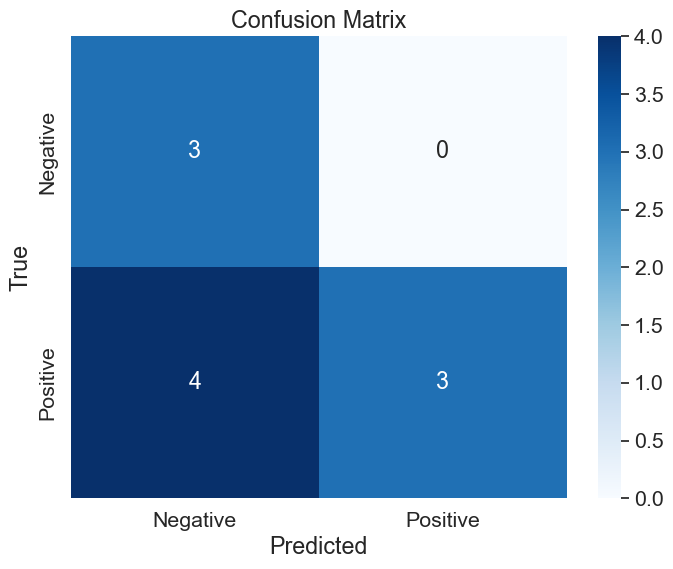

In [50]:
for lb in [11]:
    count = 0
    pred_status_list, true_status_list = [], []
    last_price_list = []
    pred_1_list, pred_2_list = [], []
    total_last_stock_price, total_gamble_stock_price = 0, 0
    total_pred_stock_price, total_true_stock_price = 0, 0
    total_proft = 0

    for ticker in symbols[:10]:
        count += 1
        price = database[ticker]
        act_status, last_price, pred1, pred2, true_price1, true_price2 = predict2(price, look_back = lb, epochs=500, ticker=ticker, plot_graph = False)
            
        true_proft = true_price1 - last_price
        pred_status_list.append(act_status)
        last_price_list.append(last_price)
        pred_1_list.append(pred1)
        pred_2_list.append(pred2)    
            
        my_act_status = act_status
        my_gamble = sell_price(last_price, pred1, pred2)
        gamble_proft = my_gamble/last_price
        sold_status = check_sold(my_gamble, true_price1)
        
        if my_gamble/last_price < 1.0008 and my_act_status == True: 
            my_act_status = False
        if my_act_status == False: 
            sold_status = None
            gamble_proft = None
            
        print(ticker, 'Count:', count, '/ LastPrice:', last_price, '/ Pred1:', pred1, '/ Pred2:', pred2, '/ TruePrice1:', true_price1, '/ TruePrice2:', true_price2, 
              '|| ActStatus:', act_status, '/ MyActStatus:', my_act_status, '/ MyGamble:', my_gamble, '/ SoldStatus:', sold_status, '/ GambleProft:', gamble_proft, '/ CorrectModel:', act_status == ((true_price1 - last_price) > 0))
        
        
        if act_status:
            total_last_stock_price += last_price
            total_pred_stock_price += pred1
            total_gamble_stock_price += my_gamble
            total_true_stock_price += true_price1
        if true_proft > 0:
            true_status_list.append(True)
        if true_proft <= 0:
            true_status_list.append(False)
            
    if not total_last_stock_price == 0:
        print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
        print('Gamble proft %:', total_gamble_stock_price / total_last_stock_price)
        print('True proft %:', total_true_stock_price / total_last_stock_price)
    if total_last_stock_price == 0:
        print('\nAll False')
        
    print('\nLook_back:', lb)
    index = my_confusion_matrix(true_status_list, pred_status_list)
    for i in index:
        print(symbols[i])

Loss: 25074528.0
BTCBRL Count: 1 / LastPrice: 333253.0 / Pred1: 336585.66 / Pred2: 346874.6 / TruePrice1: 343050.0 / TruePrice2: 343983.0 || ActStatus: True / MyActStatus: True / MyGamble: 336585.66 / SoldStatus: True / GambleProft: 1.0100003788413008 / CorrectModel: True
Loss: 0.0004831764963455498
USDTBRL Count: 2 / LastPrice: 4.986 / Pred1: 5.00878 / Pred2: 5.0570135 / TruePrice1: 5.036 / TruePrice2: 5.042 || ActStatus: True / MyActStatus: True / MyGamble: 5.0037712225914 / SoldStatus: True / GambleProft: 1.0035642243464502 / CorrectModel: True
Loss: 55799.0390625
ETHBRL Count: 3 / LastPrice: 19296.22 / Pred1: 19638.05 / Pred2: 19929.193 / TruePrice1: 19556.48 / TruePrice2: 19605.24 || ActStatus: True / MyActStatus: True / MyGamble: 19638.05 / SoldStatus: False / GambleProft: 1.0177149089951296 / CorrectModel: True
Loss: 2814.680908203125
BNBBRL Count: 4 / LastPrice: 2368.0 / Pred1: 2378.6013 / Pred2: 2466.9497 / TruePrice1: 2449.0 / TruePrice2: 2441.0 || ActStatus: True / MyActStat

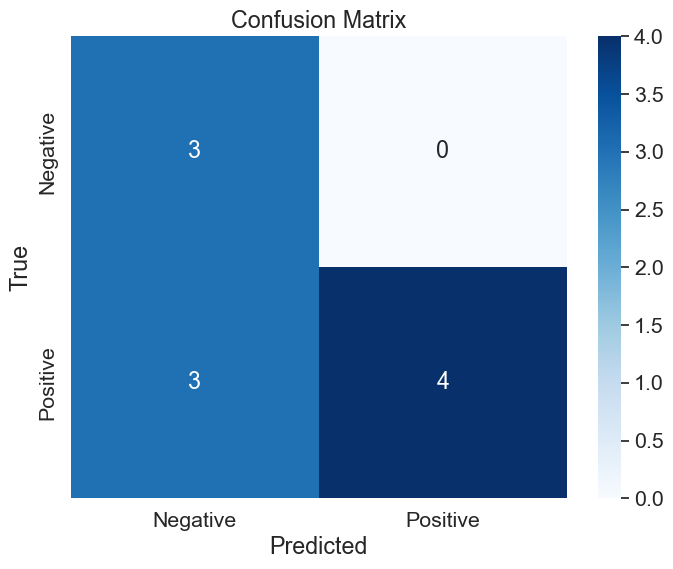

In [48]:
for lb in [11]:
    count = 0
    pred_status_list, true_status_list = [], []
    last_price_list = []
    pred_1_list, pred_2_list = [], []
    total_last_stock_price, total_gamble_stock_price = 0, 0
    total_pred_stock_price, total_true_stock_price = 0, 0
    total_proft = 0

    for ticker in symbols[:10]:
        count += 1
        price = database[ticker]
        act_status, last_price, pred1, pred2, true_price1, true_price2 = predict3(price, look_back = lb, epochs=500, ticker=ticker, plot_graph = False)
            
        true_proft = true_price1 - last_price
        pred_status_list.append(act_status)
        last_price_list.append(last_price)
        pred_1_list.append(pred1)
        pred_2_list.append(pred2)    
            
        my_act_status = act_status
        my_gamble = sell_price(last_price, pred1, pred2)
        gamble_proft = my_gamble/last_price
        sold_status = check_sold(my_gamble, true_price1)
        
        if my_act_status == True and gamble_proft < 1.0008: 
            my_act_status = False
            
        if my_act_status == False: 
            sold_status = None
            gamble_proft = None
            
        print(ticker, 'Count:', count, '/ LastPrice:', last_price, '/ Pred1:', pred1, '/ Pred2:', pred2, '/ TruePrice1:', true_price1, '/ TruePrice2:', true_price2, 
              '|| ActStatus:', act_status, '/ MyActStatus:', my_act_status, '/ MyGamble:', my_gamble, '/ SoldStatus:', sold_status, '/ GambleProft:', gamble_proft, 
              '/ CorrectModel:', act_status == ((true_price1 - last_price) > 0))
        
        if act_status:
            total_last_stock_price += last_price
            total_pred_stock_price += pred1
            total_gamble_stock_price += my_gamble
            total_true_stock_price += true_price1
        if true_proft > 0:
            true_status_list.append(True)
        if true_proft <= 0:
            true_status_list.append(False)
            
    if not total_last_stock_price == 0:
        print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
        print('Gamble proft %:', total_gamble_stock_price / total_last_stock_price)
        print('True proft %:', total_true_stock_price / total_last_stock_price)
    if total_last_stock_price == 0:
        print('\nAll False')
        
    print('\nLook_back:', lb)
    bad_index = my_confusion_matrix(true_status_list, pred_status_list)
    for i in bad_index:
        print(symbols[i])

In [55]:
for lb in [11]:
    count = 0
    pred_status_list, true_status_list = [], []
    last_price_list = []
    pred_1_list, pred_2_list = [], []
    total_last_stock_price, total_gamble_stock_price = 0, 0
    total_pred_stock_price, total_true_stock_price = 0, 0
    total_proft = 0

    for ticker in symbols[:10]:
        count += 1
        price = database[ticker]
        act_status, last_price, pred1, pred2, true_price1, true_price2 = predict4(price, look_back = lb, epochs=250, ticker=ticker, plot_graph = False)
            
        true_proft = true_price1 - last_price
        pred_status_list.append(act_status)
        last_price_list.append(last_price)
        pred_1_list.append(pred1)
        pred_2_list.append(pred2)    
            
        my_act_status = act_status
        my_gamble = sell_price(last_price, pred1, pred2)
        gamble_proft = my_gamble/last_price
        sold_status = check_sold(my_gamble, true_price1)
        
        if my_act_status == True and gamble_proft < 1.0008: 
            my_act_status = False
            
        if my_act_status == False: 
            sold_status = None
            gamble_proft = None
            
        print(ticker, 'Count:', count, '/ LastPrice:', last_price, '/ Pred1:', pred1, '/ Pred2:', pred2, '/ TruePrice1:', true_price1, '/ TruePrice2:', true_price2, 
              '|| ActStatus:', act_status, '/ MyActStatus:', my_act_status, '/ MyGamble:', my_gamble, '/ SoldStatus:', sold_status, '/ GambleProft:', gamble_proft, 
              '/ CorrectModel:', act_status == ((true_price1 - last_price) > 0))
        
        if act_status:
            total_last_stock_price += last_price
            total_pred_stock_price += pred1
            total_gamble_stock_price += my_gamble
            total_true_stock_price += true_price1
        if true_proft > 0:
            true_status_list.append(True)
        if true_proft <= 0:
            true_status_list.append(False)
            
    if not total_last_stock_price == 0:
        print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
        print('Gamble proft %:', total_gamble_stock_price / total_last_stock_price)
        print('True proft %:', total_true_stock_price / total_last_stock_price)
    if total_last_stock_price == 0:
        print('\nAll False')
        
    print('\nLook_back:', lb)
    bad_index = my_confusion_matrix(true_status_list, pred_status_list)
    for i in bad_index:
        print(symbols[i])

Loss: 16730218.0
BTCBRL Count: 1 / LastPrice: 333253.0 / Pred1: 339055.1 / Pred2: 348166.5 / TruePrice1: 343050.0 / TruePrice2: 343983.0 || ActStatus: True / MyActStatus: True / MyGamble: 339055.1 / SoldStatus: True / GambleProft: 1.0174104771749992 / CorrectModel: True


KeyboardInterrupt: 

In [56]:
for lb in [11]:
    count = 0
    pred_status_list, true_status_list = [], []
    last_price_list = []
    pred_1_list, pred_2_list = [], []
    total_last_stock_price, total_gamble_stock_price = 0, 0
    total_pred_stock_price, total_true_stock_price = 0, 0
    total_proft = 0

    for ticker in symbols[:10]:
        count += 1
        price = database[ticker]
        act_status, last_price, pred1, pred2, true_price1, true_price2 = predict5(price, look_back = lb, epochs=250, ticker=ticker, plot_graph = False)
            
        true_proft = true_price1 - last_price
        pred_status_list.append(act_status)
        last_price_list.append(last_price)
        pred_1_list.append(pred1)
        pred_2_list.append(pred2)    
            
        my_act_status = act_status
        my_gamble = sell_price(last_price, pred1, pred2)
        gamble_proft = my_gamble/last_price
        sold_status = check_sold(my_gamble, true_price1)
        
        if my_act_status == True and gamble_proft < 1.0008: 
            my_act_status = False
            
        if my_act_status == False: 
            sold_status = None
            gamble_proft = None
            
        print(ticker, 'Count:', count, '/ LastPrice:', last_price, '/ Pred1:', pred1, '/ Pred2:', pred2, '/ TruePrice1:', true_price1, '/ TruePrice2:', true_price2, 
              '|| ActStatus:', act_status, '/ MyActStatus:', my_act_status, '/ MyGamble:', my_gamble, '/ SoldStatus:', sold_status, '/ GambleProft:', gamble_proft, 
              '/ CorrectModel:', act_status == ((true_price1 - last_price) > 0))
        
        if act_status:
            total_last_stock_price += last_price
            total_pred_stock_price += pred1
            total_gamble_stock_price += my_gamble
            total_true_stock_price += true_price1
        if true_proft > 0:
            true_status_list.append(True)
        if true_proft <= 0:
            true_status_list.append(False)
            
    if not total_last_stock_price == 0:
        print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
        print('Gamble proft %:', total_gamble_stock_price / total_last_stock_price)
        print('True proft %:', total_true_stock_price / total_last_stock_price)
    if total_last_stock_price == 0:
        print('\nAll False')
        
    print('\nLook_back:', lb)
    bad_index = my_confusion_matrix(true_status_list, pred_status_list)
    for i in bad_index:
        print(symbols[i])

Loss: 117997125632.0
BTCBRL Count: 1 / LastPrice: 333253.0 / Pred1: [9.726283] / Pred2: [9.726283] / TruePrice1: 343050.0 / TruePrice2: 343983.0 || ActStatus: [False] / MyActStatus: [False] / MyGamble: 333253.0 / SoldStatus: None / GambleProft: None / CorrectModel: [False]
Loss: 0.03174537792801857
USDTBRL Count: 2 / LastPrice: 4.986 / Pred1: [5.217147] / Pred2: [5.217147] / TruePrice1: 5.036 / TruePrice2: 5.042 || ActStatus: [ True] / MyActStatus: [ True] / MyGamble: [5.21193] / SoldStatus: [False] / GambleProft: [1.0453129] / CorrectModel: [ True]
Loss: 67940128.0
ETHBRL Count: 3 / LastPrice: 19296.22 / Pred1: [11207.59] / Pred2: [11209.909] / TruePrice1: 19556.48 / TruePrice2: 19605.24 || ActStatus: [False] / MyActStatus: [False] / MyGamble: 19296.22 / SoldStatus: None / GambleProft: None / CorrectModel: [False]
Loss: 527293.1875
BNBBRL Count: 4 / LastPrice: 2368.0 / Pred1: [1664.1703] / Pred2: [1664.1703] / TruePrice1: 2449.0 / TruePrice2: 2441.0 || ActStatus: [False] / MyActStatus

KeyboardInterrupt: 

# Make a dataframe and save results

In [ ]:
dic = {"Ticker":[],"Act":[],"LastPrice":[],"Pred1":[],"Pred2":[]}
for ticker, status, last_price, pred_1, pred_2 in zip(symbols, pred_status_list, last_price_list, pred_1_list, pred_2_list):
    dic["Ticker"].append(ticker)
    dic["Act"].append(status)
    dic["LastPrice"].append(last_price)
    dic["Pred1"].append(pred_1)
    dic["Pred2"].append(pred_2)
df = pd.DataFrame(dic)
display(df)
display(df.loc[df["Act"]==True])

In [ ]:
#csv_file = df.to_csv(f"Prediction_{present_day}.csv",index=False)

In [ ]:
pred_status_list, true_status_list = [], []
last_price_list = []
pred_1_list, pred_2_list = [], []
total_last_stock_price, total_pred_stock_price, total_true_stock_price = 0, 0, 0

for ticker in symbols:
    price = database[ticker]
    status, last_price, pred1, pred2, true_price1, true_price2 = predict(price, ticker=ticker)
    pred_status_list.append(status)
    last_price_list.append(last_price)
    pred_1_list.append(pred1)
    pred_2_list.append(pred2)
    pred_proft, true_proft = pred1 - last_price, true_price1 - last_price
    if status:
        total_last_stock_price += last_price
        total_pred_stock_price += pred1
        total_true_stock_price += true_price1
    if true_proft > 0:
        true_status_list.append(True)
    if true_proft <= 0:
        true_status_list.append(False)

print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
print('\nTrue proft %:', total_true_stock_price / total_last_stock_price)
my_confusion_matrix(true_status_list, pred_status_list)

In [50]:
max_crypto = ''
min_crypto = ''
max_max_value = 0
min_max_value = 1e3
for ticker in symbols:
    price = database[ticker]
    max_value = max(price)
    if max_value > max_max_value:
        max_max_value = max_value
        max_crypto = ticker
    if max_value < min_max_value:
        min_max_value = max_value
        min_crypto = ticker
        
print('MaxCrypto:', max_crypto, max_max_value)
print('MinCrypto:', min_crypto, min_max_value)

MaxCrypto: BTCBRL 376520.0
MinCrypto: SHIBBRL 0.00044702
